# MRI Reconstruction from Non-Cartesian Samples

**Problem:** MRI scanners often acquire data along non-Cartesian trajectories (radial, spiral) for faster scanning or motion robustness. You need to reconstruct the image.

The forward model (image → k-space samples) uses Type 2 NUFFT, and the adjoint (k-space → image) uses Type 1 with density compensation.

## Setup

First, install nufftax if running on Colab:

In [1]:
# Uncomment the following lines to install nufftax on Colab
# !pip install uv
# !uv pip install nufftax --system

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from nufftax import nufft2d1, nufft2d2
import matplotlib.pyplot as plt

## Mathematical Background

**Forward model** (image → k-space samples) uses Type 2:

$$y[j] = \frac{1}{\text{norm}} \sum_k x_k \cdot e^{i (k_x[j] \cdot r_k + k_y[j] \cdot c_k)}$$

**Adjoint** (k-space → image) uses Type 1 with density compensation.

## Define MRI Operators

In [3]:
# Normalization factor (following standard convention)
def compute_norm_factor(shape):
    return np.sqrt(np.prod(shape) * 4)  # sqrt(H*W*2^ndim) for 2D

# Density compensation for radial trajectories
def compute_radial_dcf(kx, ky):
    rho = jnp.sqrt(kx**2 + ky**2)
    weights = jnp.maximum(rho, 1e-6)
    return weights / weights.mean()

# Generate radial trajectory (spokes through k-space center)
def generate_radial_trajectory(num_spokes, num_samples, in_out=True):
    angles = jnp.arange(num_spokes) * (jnp.pi / num_spokes)
    segment = jnp.linspace(-1, 1, num_samples) if in_out else jnp.linspace(0, 1, num_samples)
    radius = jnp.pi * segment
    kx = jnp.outer(jnp.cos(angles), radius).ravel()
    ky = jnp.outer(jnp.sin(angles), radius).ravel()
    return kx, ky

# Forward model: image -> k-space (Type 2)
def forward(img, kx, ky, norm):
    return nufft2d2(kx, ky, img, eps=1e-6) / norm

# Adjoint model: k-space -> image (Type 1 with DCF)
def adjoint(kspace, kx, ky, shape, norm):
    dcf = compute_radial_dcf(kx, ky)
    return nufft2d1(kx, ky, kspace * dcf, n_modes=shape, eps=1e-6) / norm

## Load Brain MRI Image

In [4]:
# Load real brain MRI image
# For Colab, you can download from the repo:
# !wget https://raw.githubusercontent.com/geoffroyO/nufftax/main/docs/_static/brain_mri.npy

try:
    phantom = jnp.array(np.load('../_static/brain_mri.npy'), dtype=jnp.complex64)
except FileNotFoundError:
    # Fallback: create synthetic phantom if file not found
    def create_shepp_logan_phantom(size):
        img = np.zeros((size, size), dtype=np.float32)
        y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
        mask = (x/0.69/size*2)**2 + (y/0.92/size*2)**2 < 1
        img[mask] = 1.0
        mask = (x/0.6/size*2)**2 + (y/0.8/size*2)**2 < 1
        img[mask] = 0.8
        mask = ((x+0.22*size)/0.11/size*2)**2 + (y/0.31/size*2)**2 < 1
        img[mask] = 0.2
        return img
    phantom = jnp.array(create_shepp_logan_phantom(320), dtype=jnp.complex64)

img_shape = phantom.shape
print(f"Image shape: {img_shape}")

Image shape: (320, 320)


## Simulate MRI Acquisition and Reconstruction

In [5]:
# Generate radial trajectory
num_spokes = 32
num_samples = img_shape[0]
kx, ky = generate_radial_trajectory(num_spokes, num_samples)
norm = compute_norm_factor(img_shape)

print(f"Number of k-space samples: {len(kx)}")
print(f"Normalization factor: {norm:.2f}")

# Forward: acquire k-space data
kspace = forward(phantom, kx, ky, norm)

# Adjoint: reconstruct image
recon = adjoint(kspace, kx, ky, img_shape, norm)

Number of k-space samples: 10240
Normalization factor: 640.00


## Visualization

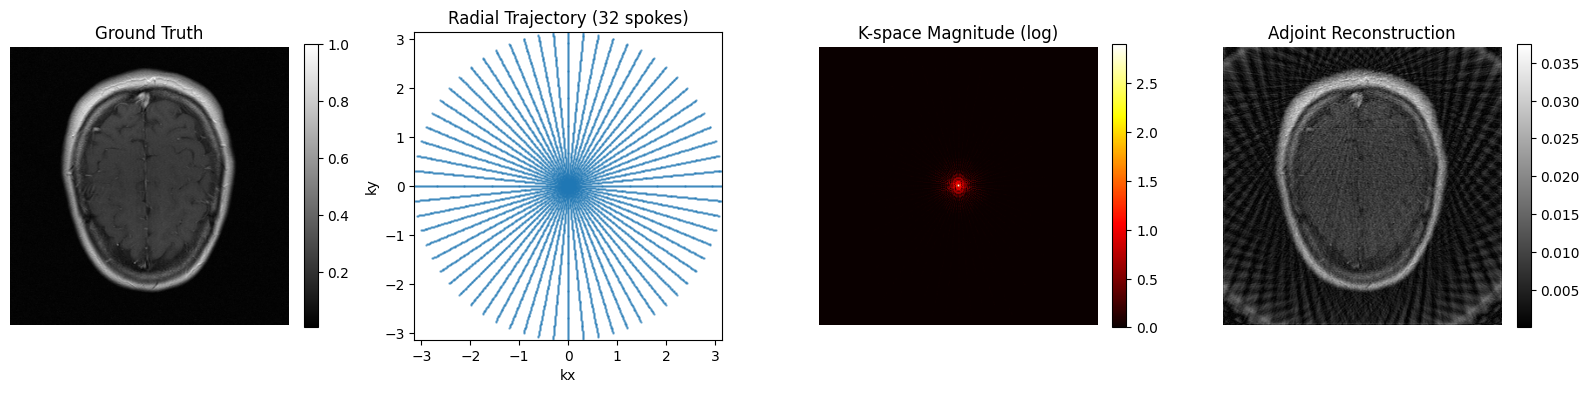

In [6]:
# Plotting code (click to expand)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original phantom
ax = axes[0]
im = ax.imshow(np.abs(phantom), cmap='gray')
ax.set_title('Ground Truth')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Trajectory
ax = axes[1]
ax.scatter(np.array(kx), np.array(ky), s=0.5, alpha=0.5)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_aspect('equal')
ax.set_title(f'Radial Trajectory ({num_spokes} spokes)')
ax.set_xlabel('kx')
ax.set_ylabel('ky')

# K-space magnitude
ax = axes[2]
kspace_2d = np.zeros(img_shape, dtype=complex)
# Bin k-space samples for visualization
kx_idx = ((np.array(kx) + np.pi) / (2*np.pi) * img_shape[0]).astype(int) % img_shape[0]
ky_idx = ((np.array(ky) + np.pi) / (2*np.pi) * img_shape[1]).astype(int) % img_shape[1]
for i in range(len(kx)):
    kspace_2d[ky_idx[i], kx_idx[i]] = np.array(kspace)[i]
im = ax.imshow(np.log1p(np.abs(kspace_2d)), cmap='hot')
ax.set_title('K-space Magnitude (log)')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Reconstruction
ax = axes[3]
im = ax.imshow(np.abs(recon), cmap='gray')
ax.set_title('Adjoint Reconstruction')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()